In [1]:
'''Trains WGAN on MNIST using Keras
Trains a GAN using Wassertein loss. Similar to DCGAN except for
linear activation in output and use of n_critic training per
adversarial training. Discriminator weights are clipped as a
requirement of Lipschitz constraint.
[1] Radford, Alec, Luke Metz, and Soumith Chintala.
"Unsupervised representation learning with deep convolutional
generative adversarial networks." arXiv preprint arXiv:1511.06434 (2015).
[2] Arjovsky, Martin, Soumith Chintala, and Léon Bottou.
"Wasserstein GAN." arXiv preprint arXiv:1701.07875 (2017).
'''

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Input
from keras.optimizers import RMSprop
from keras.models import Model
from keras.datasets import mnist
from keras import backend as K
from keras.models import load_model

import numpy as np
import argparse

import sys

## to import gan.py at "../lib/gan.py"
sys.path.append("..")
from lib import gan

Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
def train(models, x_train, params):
    """Train the Discriminator and Adversarial Networks
    Alternately train Discriminator and Adversarial networks by batch.
    Discriminator is trained first with properly labelled real and fake images
    for n_critic times.
    Discriminator weights are clipped as a requirement of Lipschitz constraint.
    Generator is trained next (via Adversarial) with fake images
    pretending to be real.
    Generate sample images per save_interval
    # Arguments
        models (list): Generator, Discriminator, Adversarial models
        x_train (tensor): Train images
        params (list) : Networks parameters
    """
    # the GAN models
    generator, discriminator, adversarial = models
    # network parameters
    (batch_size, latent_size, n_critic, 
            clip_value, train_steps, model_name) = params
    # the generator image is saved every 500 steps
    save_interval = 500
    # noise vector to see how the generator output evolves during training
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, latent_size])
    # number of elements in train dataset
    train_size = x_train.shape[0]
    # labels for real data
    real_labels = np.ones((batch_size, 1))
    for i in range(train_steps):
        # train discriminator n_critic times
        loss = 0
        acc = 0
        for _ in range(n_critic):
            # train the discriminator for 1 batch
            # 1 batch of real (label=1.0) and fake images (label=-1.0)
            # randomly pick real images from dataset
            rand_indexes = np.random.randint(0, train_size, size=batch_size)
            real_images = x_train[rand_indexes]
            # generate fake images from noise using generator
            # generate noise using uniform distribution
            noise = np.random.uniform(-1.0,
                                      1.0,
                                      size=[batch_size, latent_size])
            fake_images = generator.predict(noise)

            # train the discriminator network
            # real data label=1, fake data label=-1
            # instead of 1 combined batch of real and fake images,
            # train with 1 batch of real data first, then 1 batch
            # of fake images.
            # this tweak prevents the gradient from vanishing due to opposite
            # signs of real and fake data labels (i.e. +1 and -1) and 
            # small magnitude of weights due to clipping.
            real_loss, real_acc = discriminator.train_on_batch(real_images,
                                                               real_labels)
            fake_loss, fake_acc = discriminator.train_on_batch(fake_images,
                                                               -real_labels)
            # accumulate average loss and accuracy
            loss += 0.5 * (real_loss + fake_loss)
            acc += 0.5 * (real_acc + fake_acc)

            # clip discriminator weights to satisfy Lipschitz constraint
            for layer in discriminator.layers:
                weights = layer.get_weights()
                weights = [np.clip(weight,
                                   -clip_value,
                                   clip_value) for weight in weights]
                layer.set_weights(weights)

        # average loss and accuracy per n_critic training iterations
        loss /= n_critic
        acc /= n_critic
        log = "%d: [discriminator loss: %f, acc: %f]" % (i, loss, acc)

        # train the adversarial network for 1 batch
        # 1 batch of fake images with label=1.0
        # since the discriminator weights are frozen in adversarial network
        # only the generator is trained
        # generate noise using uniform distribution
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_size])
        # train the adversarial network
        # note that unlike in discriminator training,
        # we do not save the fake images in a variable
        # the fake images go to the discriminator input of the adversarial
        # for classification
        # fake images are labelled as real
        # log the loss and accuracy
        loss, acc = adversarial.train_on_batch(noise, real_labels)
        log = "%s [adversarial loss: %f, acc: %f]" % (log, loss, acc)
        print(log)
        if (i + 1) % save_interval == 0:
            if (i + 1) == train_steps:
                show = True
            else:
                show = False

            # plot generator images on a periodic basis
            gan.plot_images(generator,
                            noise_input=noise_input,
                            show=show,
                            step=(i + 1),
                            model_name=model_name)

    # save the model after training the generator
    # the trained generator can be reloaded for future MNIST digit generation
    generator.save(model_name + ".h5")

In [3]:
def wasserstein_loss(y_label, y_pred):
    return -K.mean(y_label * y_pred)

In [4]:
# load MNIST dataset
(x_train, _), (_, _) = mnist.load_data()

# reshape data for CNN as (28, 28, 1) and normalize
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255

model_name = "wgan_mnist-practice"
# network parameters
# the latent or z vector is 100-dim
latent_size = 100
# hyper parameters from WGAN paper [2]
n_critic = 5
clip_value = 0.01
batch_size = 64
lr = 5e-5
train_steps = 40000
input_shape = (image_size, image_size, 1)

In [5]:
# build discriminator model
inputs = Input(shape=input_shape, name='discriminator_input')

# WGAN uses linear activation in paper [2]
discriminator = gan.discriminator(inputs, activation='linear')

optimizer = RMSprop(lr=lr)
# WGAN discriminator uses wassertein loss
discriminator.compile(loss=wasserstein_loss,
                      optimizer=optimizer,
                      metrics=['accuracy'])

discriminator.summary()

linear
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discriminator_input (InputLa (None, 28, 28, 1)         0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)         204928    
___

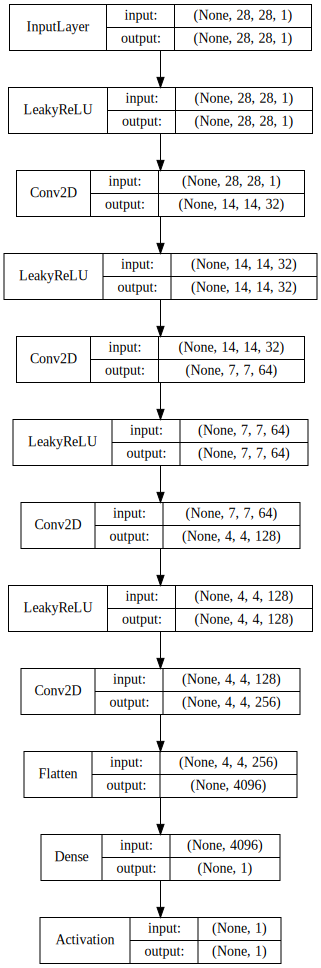

In [6]:
#  Display Model in Jupyter notebook

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

def plot_keras_model(model,show_shapes=True,show_layer_names=True):
    return SVG(model_to_dot(model,show_shapes=show_shapes,show_layer_names=show_layer_names).create(prog='dot',format='svg'))

plot_keras_model(discriminator, show_shapes=True, show_layer_names=False)

In [7]:
# build generator model
input_shape = (latent_size, )
inputs = Input(shape=input_shape, name='z_input')
generator = gan.generator(inputs, image_size)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_input (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
activation_2 (Activation)    (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 128)       409728    
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 128)       512       
__________

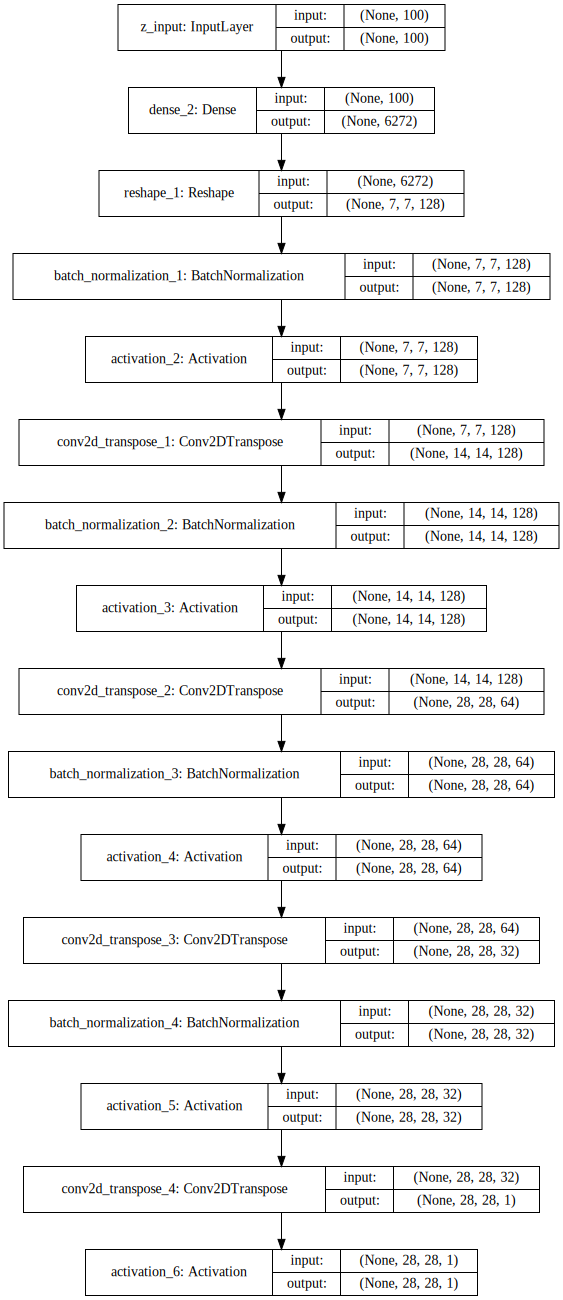

In [8]:
plot_keras_model(generator, show_shapes=True, show_layer_names=True)

In [9]:
 # build adversarial model = generator + discriminator
# freeze the weights of discriminator during adversarial training
discriminator.trainable = False
adversarial = Model(inputs,
                    discriminator(generator(inputs)),
                    name=model_name)
adversarial.compile(loss=wasserstein_loss,
                    optimizer=optimizer,
                    metrics=['accuracy'])
adversarial.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_input (InputLayer)         (None, 100)               0         
_________________________________________________________________
generator (Model)            (None, 28, 28, 1)         1301505   
_________________________________________________________________
discriminator (Model)        (None, 1)                 1080577   
Total params: 2,382,082
Trainable params: 1,300,801
Non-trainable params: 1,081,281
_________________________________________________________________


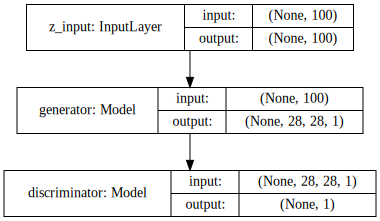

In [10]:
plot_keras_model(adversarial, show_shapes=True, show_layer_names=True)

In [11]:
# train discriminator and adversarial networks
models = (generator, discriminator, adversarial)
params = (batch_size,
          latent_size,
          n_critic,
          clip_value,
          train_steps,
          model_name)

train(models, x_train, params)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0: [discriminator loss: 0.015675, acc: 0.000000] [adversarial loss: -0.000272, acc: 0.000000]
1: [discriminator loss: 0.000072, acc: 0.000000] [adversarial loss: -0.000082, acc: 0.000000]
2: [discriminator loss: -0.000081, acc: 0.000000] [adversarial loss: 0.000310, acc: 0.000000]
3: [discriminator loss: -0.000335, acc: 0.000000] [adversarial loss: 0.000994, acc: 0.000000]
4: [discriminator loss: -0.000851, acc: 0.000000] [adversarial loss: 0.002360, acc: 0.000000]
5: [discriminator loss: -0.001966, acc: 0.000000] [adversarial loss: 0.005123, acc: 0.000000]
6: [discriminator loss: -0.004386, acc: 0.000000] [adversarial loss: 0.010667, acc: 0.000000]
7: [discriminator loss: -0.008610, acc: 0.000000] [adversarial loss: 0.020081, acc: 0.000000]
8: [discriminator loss: -0.015680, acc: 0.000000] [adversarial loss: 0.035194, acc: 0.000000]
9: [discriminator loss: -0.026440, acc: 0.000000] [adversarial loss: 0.055715, acc: 0.000000]
10: [discriminator loss: -0.040687, acc: 0.000000] [adversar

86: [discriminator loss: -0.662572, acc: 0.000000] [adversarial loss: -10.164547, acc: 0.000000]
87: [discriminator loss: -0.931459, acc: 0.000000] [adversarial loss: -9.079044, acc: 0.000000]
88: [discriminator loss: -1.346451, acc: 0.000000] [adversarial loss: -7.724043, acc: 0.000000]
89: [discriminator loss: -1.613692, acc: 0.000000] [adversarial loss: -7.107565, acc: 0.000000]
90: [discriminator loss: -1.977198, acc: 0.000000] [adversarial loss: -6.754684, acc: 0.000000]
91: [discriminator loss: -2.255083, acc: 0.000000] [adversarial loss: -6.874340, acc: 0.000000]
92: [discriminator loss: -2.383154, acc: 0.000000] [adversarial loss: -7.533371, acc: 0.000000]
93: [discriminator loss: -2.441652, acc: 0.000000] [adversarial loss: -8.957958, acc: 0.000000]
94: [discriminator loss: -2.366793, acc: 0.000000] [adversarial loss: -11.123157, acc: 0.000000]
95: [discriminator loss: -2.191553, acc: 0.000000] [adversarial loss: -13.350563, acc: 0.000000]
96: [discriminator loss: -1.769469, a

KeyboardInterrupt: 

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:269: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


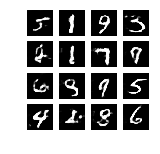

In [12]:
generator = load_model("wgan_mnist.h5")
gan.test_generator(generator)